In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation
import nltk
import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, davies_bouldin_score

In [3]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stoic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stoic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stoic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# --- Step 1: Load the dataset ---
file_path = '../data/events.csv'  # Update the path as needed
events = pd.read_csv(file_path)

In [5]:
# --- Step 2: Balance the dataset ---
min_count = events['event_type'].value_counts().min()
balanced_events = events.groupby('event_type').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

C:\Users\stoic\AppData\Local\Temp\ipykernel_15016\1533280990.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_events = events.groupby('event_type').apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


In [6]:
# --- Step 3: Preprocess the text column ---
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [7]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in punctuation and not char.isdigit()])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

In [8]:
balanced_events['processed_text'] = balanced_events['text'].apply(preprocess_text)

In [9]:
# --- Step 4: Convert text to numerical representation using TF-IDF ---
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
text_features = tfidf_vectorizer.fit_transform(balanced_events['processed_text'])

In [10]:
# --- Step 5: Apply HDBSCAN clustering ---
hdbscan_clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=30, metric='euclidean')
clusters = hdbscan_clusterer.fit_predict(text_features.toarray())
balanced_events['cluster'] = clusters

In [11]:
# --- Step 6: Evaluate the clustering ---
valid_indices = balanced_events['cluster'] != -1
valid_clusters = balanced_events[valid_indices]
dense_text_features = text_features.toarray()

In [12]:
if valid_clusters['cluster'].nunique() > 1:
    silhouette = silhouette_score(dense_text_features[valid_indices], valid_clusters['cluster'])
    ari = adjusted_rand_score(valid_clusters['event_type'], valid_clusters['cluster'])
    homogeneity = homogeneity_score(valid_clusters['event_type'], valid_clusters['cluster'])
    dbi = davies_bouldin_score(dense_text_features[valid_indices], valid_clusters['cluster'])
else:
    silhouette = ari = homogeneity = dbi = "Not Applicable"

In [13]:
print("\nClustering Results:")
print(f"Silhouette Score: {silhouette}")
print(f"Adjusted Rand Index (ARI): {ari}")
print(f"Homogeneity Score: {homogeneity}")
print(f"Davies-Bouldin Index: {dbi}")


Clustering Results:
Silhouette Score: 0.2295057357125266
Adjusted Rand Index (ARI): 0.8768646993277032
Homogeneity Score: 0.790003011510887
Davies-Bouldin Index: 1.7057289415564896


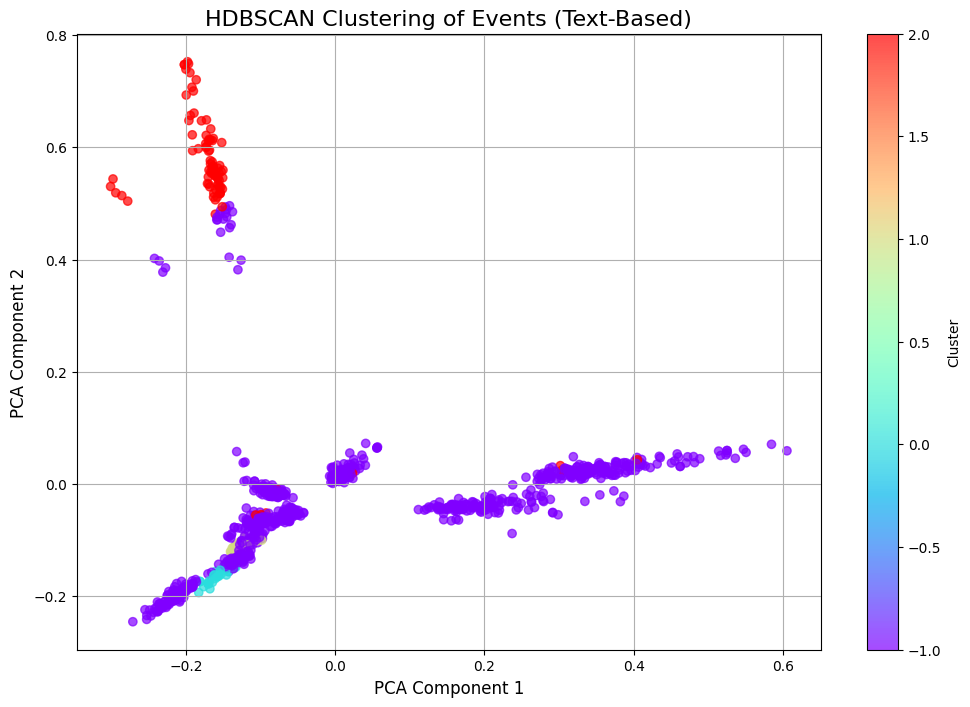

In [14]:
# --- Step 7: Visualize clusters ---
pca = PCA(n_components=2)
pca_features = pca.fit_transform(text_features.toarray())

plt.figure(figsize=(12, 8))
plt.scatter(
    pca_features[:, 0], pca_features[:, 1],
    c=balanced_events['cluster'],
    cmap='rainbow',
    alpha=0.7
)
plt.colorbar(label='Cluster')
plt.title("HDBSCAN Clustering of Events (Text-Based)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.grid(True)
plt.show()

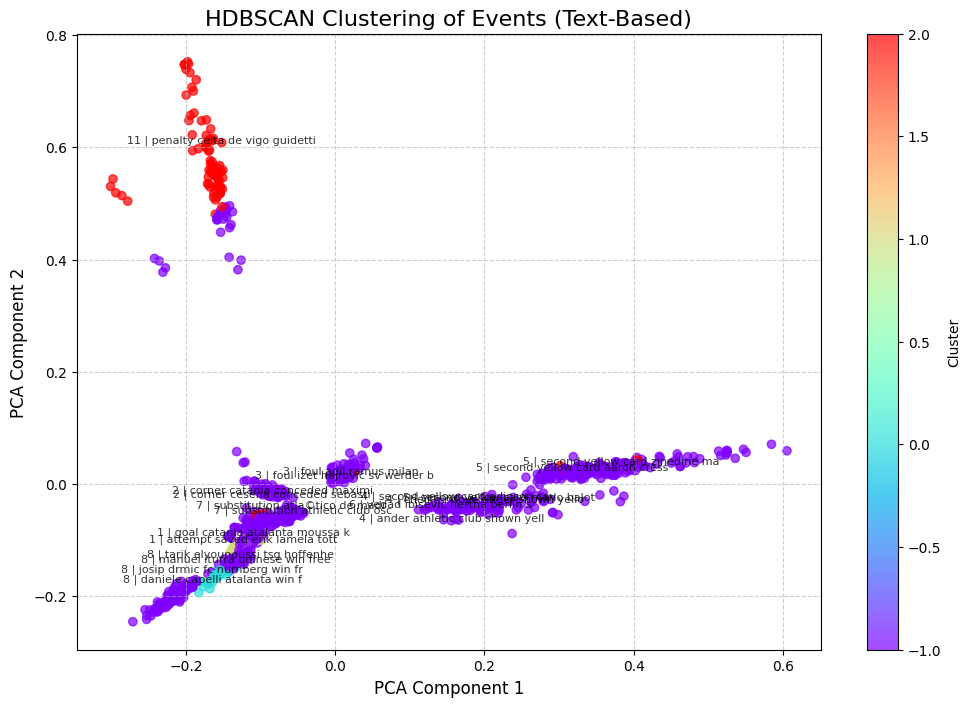

In [15]:
# Annotated Scatter Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    pca_features[:, 0], 
    pca_features[:, 1],
    c=balanced_events['cluster'],
    cmap='rainbow',
    alpha=0.7
)
plt.colorbar(scatter, label='Cluster')
plt.title("HDBSCAN Clustering of Events (Text-Based)", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)

sample_size = 20
sample_indices = balanced_events.sample(n=sample_size, random_state=42).index

for i in sample_indices:
    event_type = balanced_events.loc[i, 'event_type']
    text_snippet = balanced_events.loc[i, 'processed_text'][:30]
    plt.text(
        pca_features[i, 0], 
        pca_features[i, 1], 
        f"{event_type} | {text_snippet}", 
        fontsize=8, 
        alpha=0.8,
        ha='center'
    )

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()